## Google Colab Usage

*Please read (don't just hit run) the information given above each code cell as there are separate install cells for Colab*
&#128992;
*and running Python on your computer*
&#128309;.

**Confirm login account**
* Please make sure to be logged in with the Google account you want to use for the exercises before running the code cells below. You can check by clicking the circular account icon in the top right corner of the colab notebook.

**Working directory**
* Note: The software and data will be installed in a directory called "SSW2023/pRT" in your Google drive. This directory will be created if it does not exist.

**Running cells**
* Run cells individually by clicking on the triangle on each cell

**To Restart runtime**
*   Click on Runtime menu item
*   Select Restart runtime
*   Select Run code cells individually from the top

**To Recreate runtime**
*   Click on Runtime menu item
*   Select Disconnect and Delete runtime
*   Select Run code cells individually from the top

**To Exit:**
*   Close the browser window

# &#128992; When running on Colab: pRT installation and setup
This cell installs everything you need in Colab, as explained in the hands-on session's setup documentation.

&#128992; **Run this cell if you are running on Colab**

In [ ]:
import os

# Install MultiNest
os.chdir('/content/')
!rm -rf multinest
!git clone https://www.github.com/johannesbuchner/multinest.git
!cd multinest/build && cmake ..
!sed -i 's/-lmkl_gf_lp64 -lmkl_gnu_thread/-lmkl_mc3 -lmkl_rt -lmkl_avx2/' multinest/build/src/CMakeFiles/multinest_shared.dir/link.txt
!cd multinest/build && make && make install
!cp /content/multinest/lib/* /lib/

# Install petitRADTRANS (pRT)
import numpy as np
!pip install --no-cache-dir -U petitRADTRANS

Cloning into 'multinest'...
remote: Enumerating objects: 549, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 549 (delta 65), reused 49 (delta 19), pack-reused 431
Receiving objects: 100% (549/549), 300.02 KiB | 8.82 MiB/s, done.
Resolving deltas: 100% (342/342), done.
-- The Fortran compiler identification is GNU 11.3.0
-- The C compiler identification is GNU 11.3.0
-- The CXX compiler identification is GNU 11.3.0
-- Detecting Fortran compiler ABI info
-- Detecting Fortran compiler ABI info - done
-- Check for working Fortran compiler: /usr/bin/f95 - skipped
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile featur

&#128992; **Run the  2 cells if you are running on Colab**

This cell mounts the Google Drive (please allow it to do so) and specifies the path of the pRT input data folder. If you *are* running on Colab, but changed the default path specified in the setup notebook, please modify the path to correctly point to the input data in your Google Drive.

"SSW2023/pRT" is the default and you can leave that as-is or change it in the fill in box on the right. Be sure to pick a directory name that does not have any spaces. *This must match the directory used in the setup notebook.* This cell must be run to define the data location.

In [ ]:
# If you update the directory in the box on the right, re-run this cell
pRT_dir = 'SSW2023/pRT' #@param {type:"string"}

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount("/content/drive")

# Google top level drive dir
drive_dir = "/content/drive/MyDrive/"

# pRT directory path
pRT_path = os.path.join(drive_dir, pRT_dir)

# Confirm directory already exists per Setup
if os.path.exists(pRT_path):
  print("OK! directory '%s' exists" %pRT_path)
else:
  print("Run Setup directory '%s' does not exist" %pRT_path)

# Specify location of pRT's input data
os.environ['pRT_input_data_path'] = \
                  pRT_path+'/pRT_retrieval_SSW/input_data'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
OK! directory '/content/drive/MyDrive/SSW2023/pRT' exists


# &#128309; When running on your computer:
Please modify `absolute_path_of_the_pRT_retrieval_SSW_folder_on_your_machine` below to point to the `pRT_retrieval_SSW` folder you downloaded as described in the documentation. Then run the cell below to set the `pRT_input_data_path` environment variable accordingly. This is done such that pRT knows where the input data is.

&#128309; **Run this cell if running on your computer (not Colab!)**

In [ ]:
absolute_path_of_the_pRT_retrieval_SSW_folder_on_your_machine = '' # Please complete!

import os
import numpy as np

os.environ['pRT_input_data_path'] = \
    os.path.join(absolute_path_of_the_pRT_retrieval_SSW_folder_on_your_machine,
                 'input_data')

# petitRADTRANS: introduction exercises
## Defining an atmosphere and calculating its emission spectrum
To get started, let's calculate the emission spectrum of a hot Jupiter. The detailed description of everything that pRT allows you to do can be found in the [online tutorial](https://petitradtrans.readthedocs.io/en/latest/content/tutorial.html). Because we don't have too much time, we will only discuss a subset of this.

We start by making a pRT object, which we call `atmosphere` here; we tell it which opacity species to use, and over which wavelength range. More information on which opacity species are available can be found [here](https://petitradtrans.readthedocs.io/en/latest/content/available_opacities.html), but note that we only have a smaller selection available for the condensed input data folder we use for the Sagan Workshop. Flags like `_HITEMP` reference a specific opacity data base, `R_200` means that the opacity resolution ($\lambda / \Delta \lambda$) is equal to 200 in our example. [pRT allows users to bin down line opacities to any resolution](https://petitradtrans.readthedocs.io/en/latest/content/notebooks/Rebinning_opacities.html).

In [ ]:
import os
import numpy as np
from petitRADTRANS import Radtrans

# Line absorbers:
line_species = ['H2O_Exomol_R_200', # _Exomol stands for the water line list from Exomol.
                'CO_all_iso_HITEMP_R_200', # _R_200 means that the opacity resolution is 200.
                'CH4_hargreaves_R_200',
                'CO2_R_200',
                'SO2_R_200']

# Rayleigh scatterers
rayleigh_species = ['H2', 'He']

# Collision-induced absorption opacity
continuum_opacities = ['H2-H2', 'H2-He']

# Wavelength range for calculating spectra, in micrometer
wlen_bords_micron = [0.3, 15]

atmosphere = Radtrans(line_species = line_species,
                      rayleigh_species = rayleigh_species,
                      continuum_opacities = continuum_opacities,
                      wlen_bords_micron = wlen_bords_micron)

/usr/local/lib/python3.10/dist-packages/petitRADTRANS/radtrans.py:119: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of H2O_Exomol_R_200...
 Done.
  Read line opacities of CO_all_iso_HITEMP_R_200...
 Done.
  Read line opacities of CH4_hargreaves_R_200...
 Done.
  Read line opacities of CO2_R_200...
 Done.
  Read line opacities of SO2_R_200...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.



Next we define the vertical structure of the atmosphere, we will use 100 layers, equidistantly spaced in log(pressure) from 1 $\mu$bar to 100 bar.

In [ ]:
pressures = np.logspace(-6, 2, 100)
# tell the pRT object about the pressure grid to be used
atmosphere.setup_opa_structure(pressures)

Next we define the atmospheric temperature structure, using a [Guillot (2010)](https://ui.adsabs.harvard.edu/abs/2010A%26A...520A..27G/abstract) temperature profile. It has the following free parameters:
- $\kappa_{\rm IR}$ is the average infrared opacity (so photon absorption cross-section per unit mass of atmospheric material).
- $\gamma$ is the ratio between the optical and infrared opacity and controls whether temperature inversions form in the atmosphere.
- $T_{\rm int}$ is the internal temperature of the planet, defined such that the net planet flux radiated to space at the top of the atmosphere is $F_{\rm int}=\sigma T_{\rm int}^4$, where $\sigma$ is the Stefan-Boltzmann constant.
- $T_{\rm equ}$ is the equilibrium temperature of the planet, expressing the strength of irradiation, defined such that the planet-wide average (over the full sphere) of the stellar flux received at the location of the planet is $F_{\rm equ}=\sigma T_{\rm equ}^4$. It holds that $T_{\rm eff}^4 = T_{\rm equ}^4 + T_{\rm int}^4$, where $T_{\rm eff}$ is the planet's effective temperature.

The temperature profile is then defined like this:
$$T(\tau)^4 = \frac{3T_{\rm int}^4}{4}\left(\frac{2}{3}+\tau\right) + \frac{3T_{\rm equ}^4}{4}\left[\frac{2}{3}+\frac{1}{\gamma\sqrt{3}}+\left(\frac{\gamma}{\sqrt{3}}-\frac{1}{\gamma\sqrt{3}}\right)e^{-\gamma\tau\sqrt{3}}\right].$$
Here, $\tau$ is the so-called optical depth, which is defined as altitude in units of the mean free path of a photon. $\tau = 0$ denotes the top of the atmosphere and we go deeper (to lower altitudes) into the atmosphere for $\tau > 0$. So, when moving from the top to an altitude corresponding to $\tau=3$, say, a photon would on average be absorbed three times (which makes it unkikely, but not impossible, that a photon travels that far). One can approximate $\tau = P\kappa_{\rm IR}/g$, where $g$ is the gravitational acceleration in the atmosphere and $P$ is the pressure. In this way we can transform from $T(\tau)$ to $T(P)$.

**Please note that the Guillot (2010) formulation is "only" a useful mathematical approximation of how atmospheric temperature structures behave upon variation of fundamental input parameters. It is a useful qualitative tool, but cannot predict atmospheric pressure-temperature structures quantitatively. In general things are more complicated. Atmospheres do not just have one infrared opacity and one $\gamma$ value, instead both vary as function of wavelength and altitude. In addition, Guillot (2010) assumes that the atmosphere is 1-d, that all energy is transported by radiation, etc.** The Guillot formulation may still be a useful function to parameterize the shape of atmospheric temperature structures in a retrieval, however. In this case the best-fit parameters would not tell you anything about the true values of $\kappa_{\rm IR}$, $\gamma$, etc., since a retrieval does not know anything about the physical interpretation we associate with parameters. In this case the Guillot parameters are merely a knob to tune the temperature profile to the right shape.

In [ ]:
import pylab as plt
plt.rcParams['figure.figsize'] = (10, 6)

from petitRADTRANS.physics import guillot_global

# All I/O in petitRADTRANS in in cgs units,
# other than pressure (which is in bars) and and MMW (which is in units of amu)
# Internally, pRT does everything in cgs units.

gravity = 10**3.5 # Typical hot Jupiter gravity value

kappa_IR = 0.01 # Typical hot Jupiter opacity value.
gamma = 0.4 # This gamma leads to a non-inverted atmosphere.
T_int = 200. # Internal temperature, set by the cooling rate of the planet.
T_equ = 1500. # Euqilibrium temperature, set by the irradiation strength of the star.

temperature = guillot_global(pressures, kappa_IR, gamma, gravity, T_int, T_equ)

This is what it looks like:

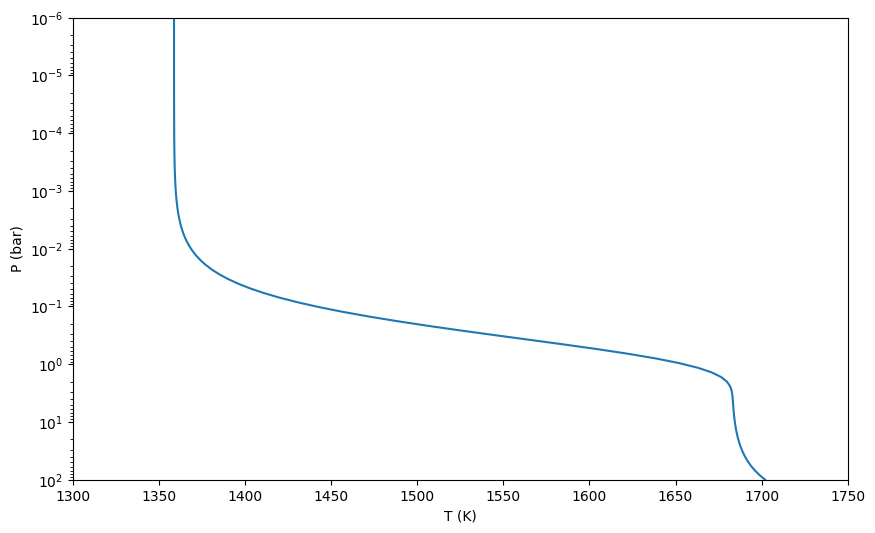

In [ ]:
plt.plot(temperature, pressures)
plt.yscale('log')
plt.xlim([1300, 1750])
plt.ylim([1e2, 1e-6])
plt.xlabel('T (K)')
plt.ylabel('P (bar)')
plt.show()